In [1]:
import phippery
from phippery.utils import *

import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# output directory
outdir = "results"
if not os.path.exists(outdir): os.mkdir(outdir)

# Okabe-Ito colors
oi_black         = '#000000'
oi_orange        = '#E69F00'
oi_skyblue       = '#56B4E9'
oi_bluishgreen   = '#009E73'
oi_yellow        = '#F0E442'
oi_blue          = '#0072B2'
oi_vermillion    = '#D55E00'
oi_reddishpurple = '#CC79A7'

# epitope region position boundaries
epitope_limits = {
    "NTD"   : [ 305, 325],
    "RBD1"  : [ 405, 439],
    "RBD2"  : [ 440, 475],
    "CTD"   : [ 660, 700],
    "preFP" : [ 770, 804],
    "FP"    : [ 805, 835],
    "SHH"   : [1135,1170]
}

# input file
ds = phippery.load("LK_DMS_1rep_layered.phip")
ds

<xarray.Dataset>
Dimensions:                      (peptide_id: 24840, peptide_metadata: 6, sample_id: 45, sample_metadata: 31)
Coordinates:
  * peptide_id                   (peptide_id) int64 0 1 2 ... 24837 24838 24839
  * sample_id                    (sample_id) int64 1461 1421 1432 ... 1467 1420
  * sample_metadata              (sample_metadata) object 'Cohort' ... 'visit...
  * peptide_metadata             (peptide_metadata) object 'Oligo' ... 'is_wt'
Data variables:
    counts                       (peptide_id, sample_id) int64 0 0 0 ... 71 1270
    sample_table                 (sample_id, sample_metadata) object nan ... nan
    peptide_table                (peptide_id, peptide_metadata) object 'aggaa...
    cpm                          (peptide_id, sample_id) float64 0.0 ... 1.35...
    size_factors                 (peptide_id, sample_id) float64 0.0 ... 1.04...
    enrichment                   (peptide_id, sample_id) float64 0.1664 ... 8...
    neg_binom_mlxp               (peptide_id, sample_id) float64 0.0 ... 3.37
    smooth_flank_1_enr_diff_sel  (peptide_id, sample_id) float64 0.4527 ... -...
Attributes:
    collapsed_variable:  None

In [3]:
# sample IDs for LK individuals
lk_infant_sams = sample_id_coordinate_subset(ds,where='sample_group',is_equal_to='LK African Infant')
lk_mother_sams = sample_id_coordinate_subset(ds,where='sample_group',is_equal_to='LK African Mother')

In [4]:
# restrict to wildtype peptides
wt_pids      = set(peptide_id_coordinate_subset(ds,where='is_wt',is_equal_to=True))
S1D614G_pids = set(peptide_id_coordinate_subset(ds,where='Protein',is_equal_to='S1D614G'))
pids_to_keep = list(wt_pids - S1D614G_pids)
pids_to_keep.sort()
wt_ds = ds.loc[dict(peptide_id=pids_to_keep)]
wt_ds

<xarray.Dataset>
Dimensions:                      (peptide_id: 1211, peptide_metadata: 6, sample_id: 45, sample_metadata: 31)
Coordinates:
  * peptide_id                   (peptide_id) int64 9 36 43 ... 24810 24827
  * sample_id                    (sample_id) int64 1461 1421 1432 ... 1467 1420
  * sample_metadata              (sample_metadata) object 'Cohort' ... 'visit...
  * peptide_metadata             (peptide_metadata) object 'Oligo' ... 'is_wt'
Data variables:
    counts                       (peptide_id, sample_id) int64 0 0 ... 503 1767
    sample_table                 (sample_id, sample_metadata) object nan ... nan
    peptide_table                (peptide_id, peptide_metadata) object 'aggaa...
    cpm                          (peptide_id, sample_id) float64 0.0 ... 1.88...
    size_factors                 (peptide_id, sample_id) float64 0.0 ... 1.45...
    enrichment                   (peptide_id, sample_id) float64 0.07187 ... ...
    neg_binom_mlxp               (peptide_id, sample_id) float64 0.0 ... 3.511
    smooth_flank_1_enr_diff_sel  (peptide_id, sample_id) float64 0.0 0.0 ... 0.0
Attributes:
    collapsed_variable:  None

## Peptide enrichment heatmap

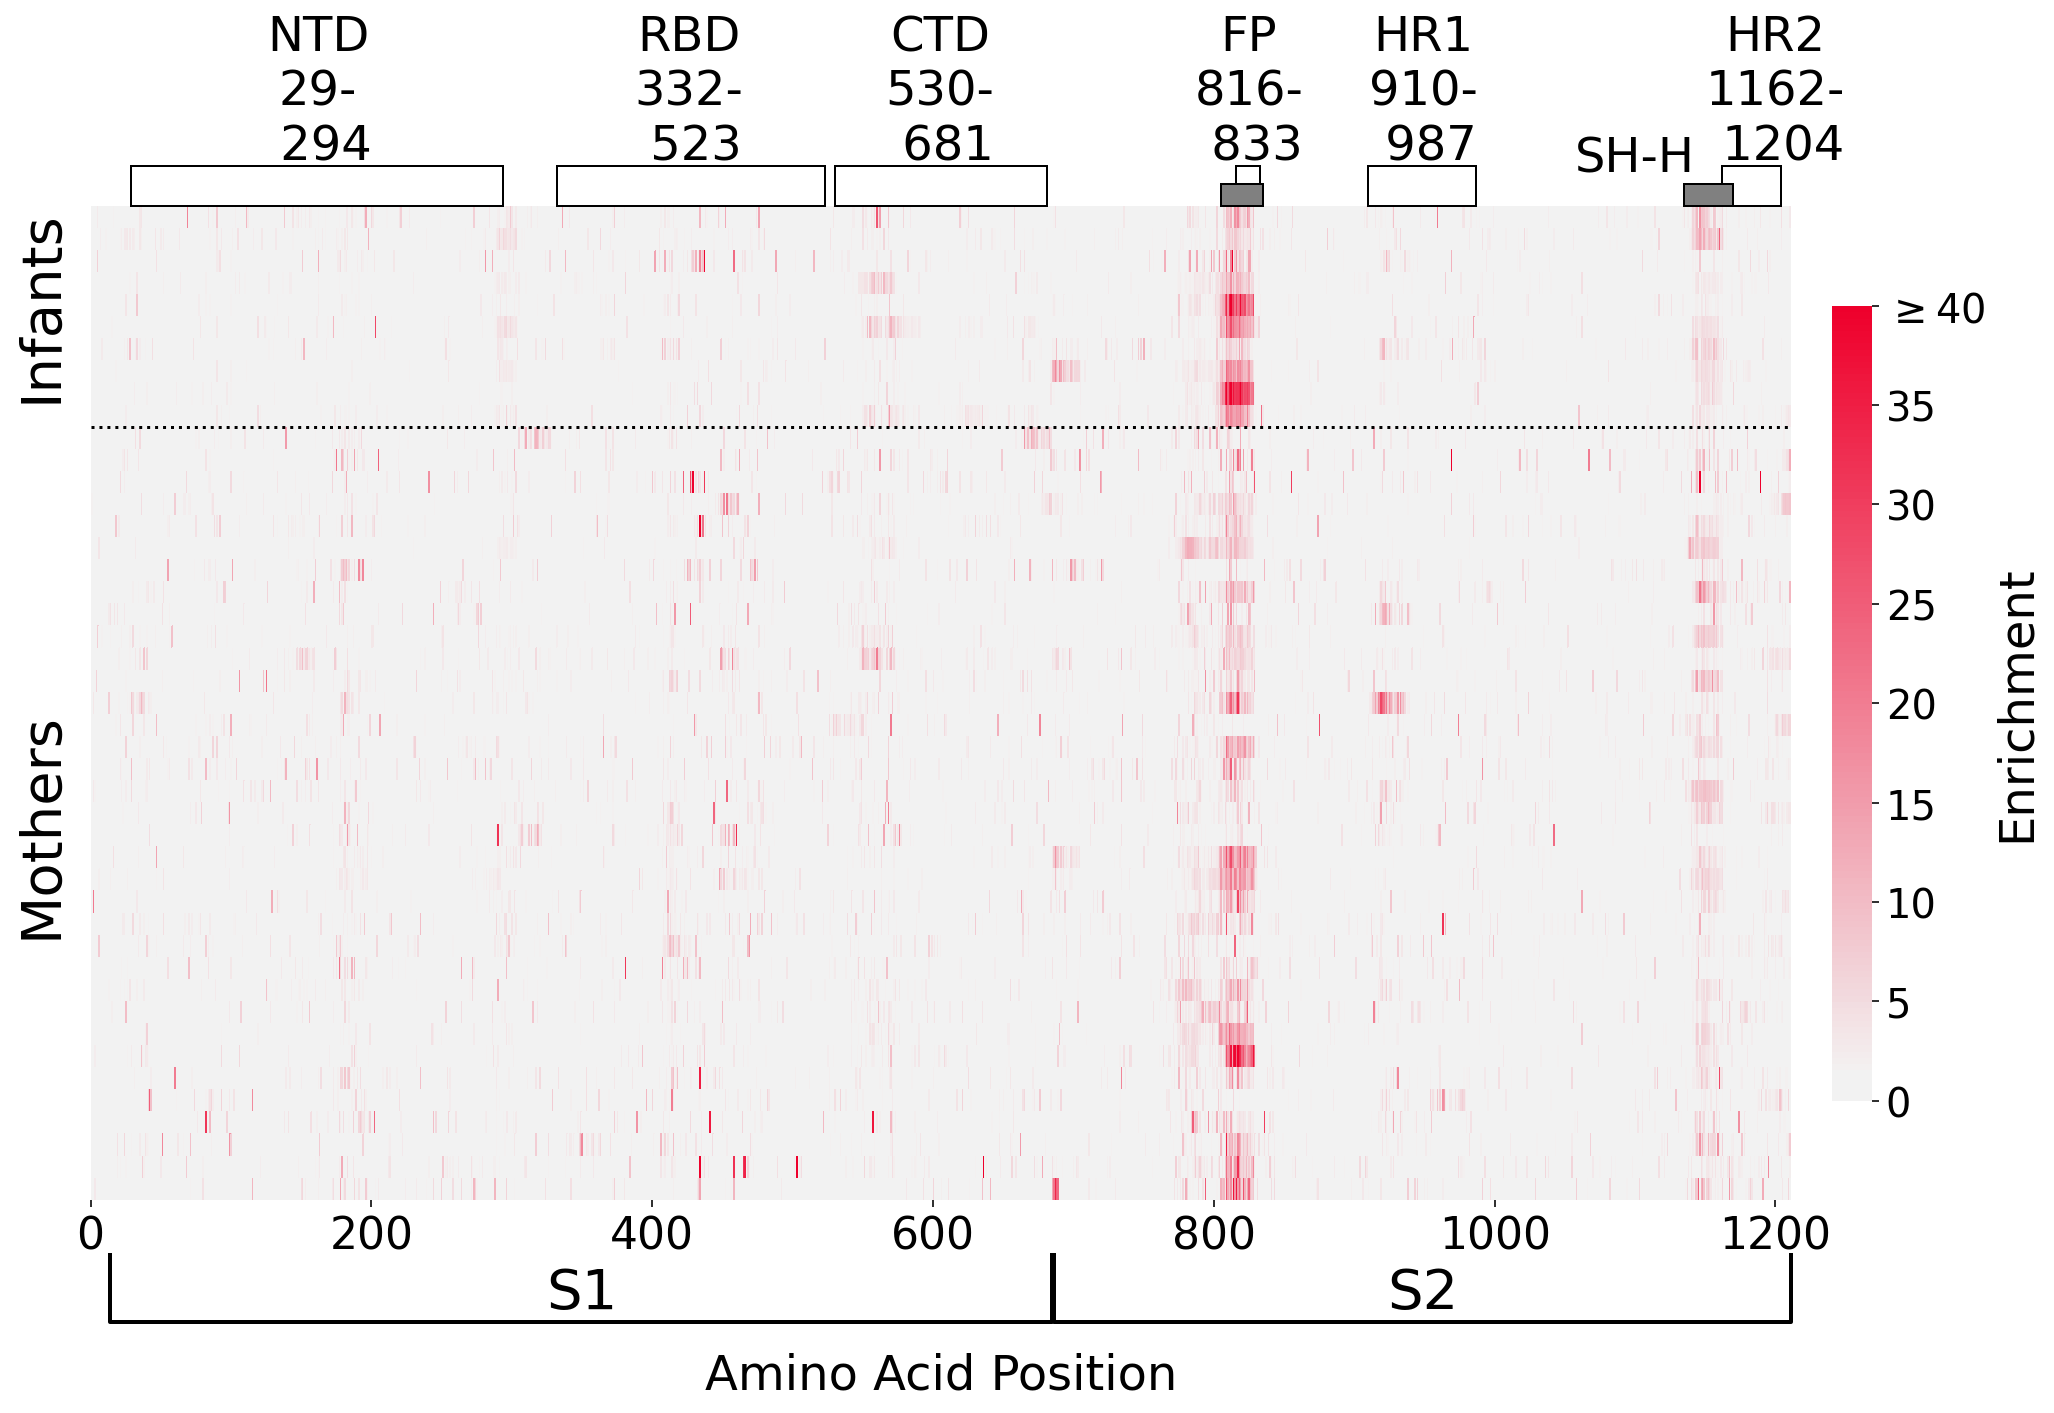

In [5]:
# ordered list of participant IDs for arranging along y-axis
yticklabels = [
    # LK Infants
      '8', '18', '25', '41', '50','142','169','185','186','133',
    # LK Mothers
      '8', '18', '25', '41', '50','142','169','185','186',
     '27', '75', '79','101','105','106','111','112','115','132',
    '139','146','149','155','166','168','172','183','189','194',
    '199','200','202','203','204','205'
]
    
ytickorder = []
istart=0
iend=0
for group in ['LK African Infant', 'LK African Mother']:
    group_sams = sample_id_coordinate_subset(wt_ds,where='sample_group',is_equal_to=group)
    group_ds = wt_ds.loc[dict(sample_id=group_sams)]
    iend = iend + len(group_sams)
    for yticklabel in yticklabels[istart:iend]:
        part_id = 'ptnum_'+yticklabel
        ytickorder.append(sample_id_coordinate_subset(group_ds,where='participant_ID',is_equal_to=part_id)[0])
    istart = istart + len(group_sams)

# set x-axis tick labels to show
xticklabels = [0,200,400,600,800,1000,1200]

#
# Organize data for heatmap plotting
#
heatmap_df = pd.DataFrame(columns=wt_ds.peptide_table.loc[:,'Loc'].values.tolist())
for sid in wt_ds.sample_id.values:
    sam_ds  = wt_ds.loc[dict(sample_id=sid)]
    enr     = sam_ds.enrichment.values.tolist()
    heatmap_df.loc[sid] = enr

heatmap_df = heatmap_df.reindex(ytickorder)  

#
# Plot heatmap
#
vmin=0
vmax=40

fig, ax = plt.subplots(figsize=[15,10])
fig.patch.set_facecolor('white')
cmap = sns.diverging_palette(240, 10, s=100, l=50, sep=10, as_cmap=True)
sns_ax = sns.heatmap(heatmap_df, cmap=cmap, center=0, square=False, linewidths=0.0, vmin=vmin, vmax=vmax,
                     cbar_kws={"shrink": 0.8, "label": "Enrichment", "pad": 0.02})

# x-axis labeling
ax.tick_params(axis="x", labelsize=22, rotation=0)
ax.set_xlabel('\nAmino Acid Position', fontsize=24, verticalalignment='top', labelpad=20)
ax.xaxis.set_major_locator(plt.FixedLocator(xticklabels))
ax.set_xticklabels(xticklabels)
plt.plot([14,14,685,685],[47.5,50.5,50.5,47.5], color='k', linewidth=2,clip_on=False)
plt.plot([686,686,1211,1211],[47.5,50.5,50.5,47.5], color='k', linewidth=2,clip_on=False)
ax.text(350, 49.2, 'S1', fontsize=28, color='k', ha='center', va='center')
ax.text(949, 49.2, 'S2', fontsize=28, color='k', ha='center', va='center')

# y-axis labeling
ax.set_yticks([])
ax.set_yticklabels([])
plt.axhline(y=10, color='k', linestyle=':')
ax.text(-35,  4.5, 'Infants', fontsize=28, color='k', ha='center', va='center', rotation=90)
ax.text(-35, 28, 'Mothers', fontsize=28, color='k', ha='center', va='center', rotation=90)

# color-bar settings
sns_ax.figure.axes[-1].yaxis.label.set_size(24)
sns_ax.collections[0].colorbar.ax.tick_params(labelsize=20)
sns_ax.collections[0].colorbar.ax.set_yticklabels([0,5,10,15,20,25,30,35,f'$\geq40$'])

# labeling epitope regions
ax.add_patch(Rectangle((1162,-1.8),(1204-1162),1.8,clip_on=False,fill=False))
ax.text(1200, -5.2, 'HR2\n1162-\n 1204', fontsize=24, color='k', ha='center', va='center')
ax.text(1100, -2.2, 'SH-H', fontsize=24, color='k', ha='center', va='center')
ax.add_patch(Rectangle(( 910,-1.8),( 987- 910),1.8,clip_on=False,fill=False))
ax.text(949, -5.2, 'HR1\n910-\n 987', fontsize=24, color='k', ha='center', va='center')
ax.add_patch(Rectangle(( 816,-1.8),( 833- 816),1.8,clip_on=False,fill=False))
ax.text(825, -5.2, 'FP\n816-\n 833', fontsize=24, color='k', ha='center', va='center')
ax.add_patch(Rectangle(( 530,-1.8),( 681- 530),1.8,clip_on=False,fill=False))
ax.text(605, -5.2, 'CTD\n530-\n 681', fontsize=24, color='k', ha='center', va='center')
ax.add_patch(Rectangle(( 332,-1.8),( 523- 332),1.8,clip_on=False,fill=False))
ax.text(426, -5.2, 'RBD\n332-\n 523', fontsize=24, color='k', ha='center', va='center')
ax.add_patch(Rectangle((  29,-1.8),( 294-  29),1.8,clip_on=False,fill=False))
ax.text(162, -5.2, 'NTD\n29-\n 294', fontsize=24, color='k', ha='center', va='center')
ax.add_patch(Rectangle((1135,-1),(1170-1135),1,clip_on=False,fill=True,edgecolor='k',facecolor='gray'))
ax.add_patch(Rectangle(( 805,-1),( 835- 805),1,clip_on=False,fill=True,edgecolor='k',facecolor='gray'))

plt.tight_layout()
plt.savefig(f"{outdir}/LK_enrichments_short.pdf")
plt.show()

## Summed enrichments in epitope regions

In [6]:
# Organize participant IDs by mother/infant and HIV status

HIV_pos_mothers = [
      'ptnum_8', 'ptnum_25', 'ptnum_41', 'ptnum_79','ptnum_106','ptnum_111','ptnum_112','ptnum_115','ptnum_139','ptnum_155',
    'ptnum_183','ptnum_185','ptnum_186','ptnum_189','ptnum_199','ptnum_200','ptnum_202','ptnum_203','ptnum_204','ptnum_205'
]

HIV_neg_mothers = [
     'ptnum_18', 'ptnum_27', 'ptnum_50', 'ptnum_75','ptnum_101','ptnum_105','ptnum_132','ptnum_142','ptnum_146','ptnum_149',
    'ptnum_166','ptnum_168','ptnum_169','ptnum_172','ptnum_194'
]

lk_mother_ds = ds.loc[dict(sample_id=lk_mother_sams)]
HIV_pos_mother_sams = sample_id_coordinate_subset(lk_mother_ds,where='participant_ID',is_in=HIV_pos_mothers)
HIV_neg_mother_sams = sample_id_coordinate_subset(lk_mother_ds,where='participant_ID',is_in=HIV_neg_mothers)


HIV_pos_infants = [
    'ptnum_8', 'ptnum_25', 'ptnum_41','ptnum_133','ptnum_185','ptnum_186'
]

HIV_neg_infants = [
    'ptnum_18', 'ptnum_50', 'ptnum_142','ptnum_169'
]

lk_infant_ds = ds.loc[dict(sample_id=lk_infant_sams)]
HIV_pos_infant_sams = sample_id_coordinate_subset(lk_infant_ds,where='participant_ID',is_in=HIV_pos_infants)
HIV_neg_infant_sams = sample_id_coordinate_subset(lk_infant_ds,where='participant_ID',is_in=HIV_neg_infants)

In [7]:
# Group summed enrichments by mother/infant and HIV status

HIV_pos_mother_sums   = {}
HIV_neg_mother_sums   = {}
HIV_pos_infant_sums   = {}
HIV_neg_infant_sums   = {}

HIV_pos_mother_pid   = {}
HIV_neg_mother_pid   = {}
HIV_pos_infant_pid   = {}
HIV_neg_infant_pid   = {}

for region in ['FP','SHH']:
    print(region,'epitope')
    region_locs = [loc for loc in range(epitope_limits[region][0], epitope_limits[region][1]+1)]

    HIV_pos_mother_sums[region]   = []
    HIV_neg_mother_sums[region]   = []
    HIV_pos_infant_sums[region]   = []
    HIV_neg_infant_sums[region]   = []
    
    HIV_pos_mother_pid[region]   = []
    HIV_neg_mother_pid[region]   = []
    HIV_pos_infant_pid[region]   = []
    HIV_neg_infant_pid[region]   = []
    
    group_sams_list = [HIV_pos_mother_sams, HIV_neg_mother_sams, HIV_pos_infant_sams, HIV_neg_infant_sams]
    group_sums_list = [HIV_pos_mother_sums[region], HIV_neg_mother_sums[region],
                       HIV_pos_infant_sums[region], HIV_neg_infant_sums[region]]
    group_pid_list  = [HIV_pos_mother_pid[region], HIV_neg_mother_pid[region],
                       HIV_pos_infant_pid[region], HIV_neg_infant_pid[region]]
    for group_sams, group_sums, group_pid in zip(group_sams_list, group_sums_list, group_pid_list):
        for sid in group_sams:
            region_pids = peptide_id_coordinate_subset(wt_ds,where='Loc',is_in=region_locs)
            enr = wt_ds.loc[dict(sample_id=sid, peptide_id=region_pids)].enrichment.values
            pid = wt_ds.loc[dict(sample_id=sid)].sample_table.loc['participant_ID'].item()
            group_sums.append(np.sum(enr))
            group_pid.append(pid)

FP epitope
SHH epitope


In [8]:
# Write out summed enrichments in CSV, annotate with
# participant ID, person type, HIV status, and epitope region

sums_df = pd.DataFrame(columns=['participant_ID','person','status','region','enrichment'])
for region in ['FP','SHH']:
    for p,x in zip(HIV_pos_infant_pid[region], HIV_pos_infant_sums[region]):
        sums_df.loc[len(sums_df)] = [p,'infant', 'positive', region, x]
    for p,x in zip(HIV_neg_infant_pid[region], HIV_neg_infant_sums[region]):
        sums_df.loc[len(sums_df)] = [p,'infant', 'negative', region, x]
        
    for p,x in zip(HIV_pos_mother_pid[region], HIV_pos_mother_sums[region]):
        sums_df.loc[len(sums_df)] = [p,'mother', 'positive', region, x]
    for p,x in zip(HIV_neg_mother_pid[region], HIV_neg_mother_sums[region]):
        sums_df.loc[len(sums_df)] = [p,'mother', 'negative', region, x]
        
sums_df.to_csv(f'{outdir}/summed_enrichment.csv',index=False)

FP infants vs mothers: pval = 0.014548205913238396
SHH infants vs mothers: pval = 0.7953582759212796


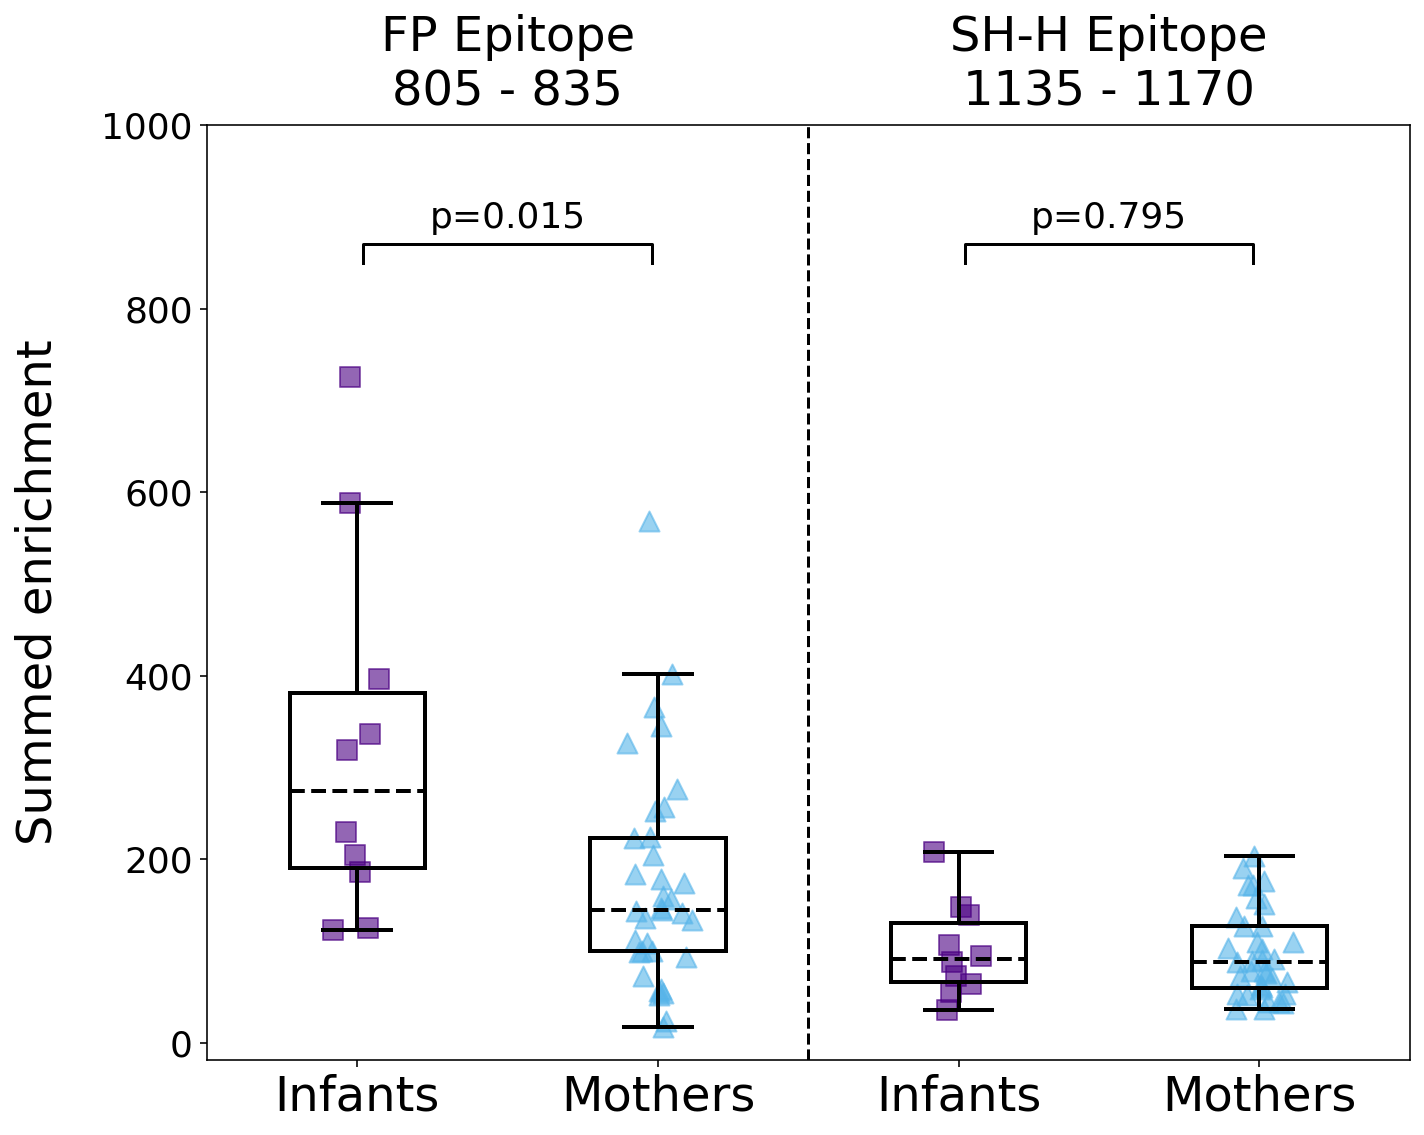

In [9]:
#
# Plot summed enrichments for FP and SH-H epitopes
#

plot_data=[]
for region in ['FP','SHH']:
    for person in ['infant','mother']:
        plot_data.append(sums_df[(sums_df['person']==person) & (sums_df['region']==region)]['enrichment'].to_numpy())

# random jitter x-axis positions 
np.random.seed(25)
infant_x = np.random.normal(1, 0.04, size=len(lk_infant_sams))
mother_x = np.random.normal(2, 0.04, size=len(lk_mother_sams))


x_data     = [infant_x, mother_x]
box_colors = ['indigo', oi_skyblue]
        
linew=2
fig = plt.figure(figsize=[10,8])
for xvals, yvals, color, marker in zip([x_data[0], x_data[1], x_data[0]+2, x_data[1]+2],
                                       plot_data,
                                       box_colors+box_colors,
                                       ['s','^','s','^']
                                      ):
    plt.scatter(xvals, yvals, color=color, marker=marker, alpha=0.6, s=100)

boxes = plt.boxplot(plot_data,
                    labels=['Infants', 'Mothers', 'Infants', 'Mothers'],
                    sym='',
                    patch_artist=True,
                    #widths=0.35,
                    boxprops=dict(linewidth=linew),
                    whiskerprops=dict(linewidth=linew),
                    capprops=dict(linewidth=linew),
                    medianprops=dict(color='k', linewidth=linew, linestyle='--'),
                    )
for patch in boxes['boxes']:
    patch.set_facecolor((0,0,0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=18)
plt.ylabel('Summed enrichment', fontsize=24, labelpad=20)
plt.axvline(x=2.5, color='k', linestyle='--')

basey = 850
plt.ylim(ymax=basey+150)

plt.text(1.5,basey+160,f'FP Epitope\n{epitope_limits["FP"][0]} - {epitope_limits["FP"][1]}',
         ha='center',va='bottom',fontsize=24)
plt.text(3.5,basey+160,f'SH-H Epitope\n{epitope_limits["SHH"][0]} - {epitope_limits["SHH"][1]}',
         ha='center',va='bottom',fontsize=24)

# p-values
us1,up1 = st.mannwhitneyu(plot_data[0], plot_data[1], alternative='two-sided')
print('FP infants vs mothers: pval =',up1)
plt.plot([1.02,1.02,1.98,1.98], [basey,basey+20,basey+20,basey], c='black')
plt.text(1.5,basey+30,f'p={round(up1,3)}',ha='center',va='bottom',fontsize=18)

us2,up2 = st.mannwhitneyu(plot_data[2], plot_data[3], alternative='two-sided')
print('SHH infants vs mothers: pval =',up2)
plt.plot([3.02,3.02,3.98,3.98], [basey,basey+20,basey+20,basey], c='black')
plt.text(3.5,basey+30,f'p={round(up2,3)}',ha='center',va='bottom',fontsize=18)

plt.tight_layout()
#plt.savefig(f"{outdir}/FP_and_SHH_LK_boxplot.pdf")
plt.show()